# Ocular Disease Recognition - Model Training

2023-08-07

## 1. Overview & Preprocessing

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

- Normal (N),
- Diabetes (D),
- Glaucoma (G),
- Cataract (C),
- Age related Macular Degeneration (A),
- Hypertension (H),
- Pathological Myopia (M),
- Other diseases/abnormalities (O)

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../data/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
import cv2

import torch
torch.__version__

'2.0.0'

### 1.1 Exploratory data analysis

An issue with the data is that the diagnosis encodings in the one-hot-encoded columns (columns labeled C, D, G...), in particular the numeric encoded diagnosis are incorrect. However the `target` field is correct for the eye referenced in `filename` and matched the diagnostic keywords for the respective eye.

In [2]:
df = pd.read_csv('/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv')

df.head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


### 1.2 Problems with the encoded categories

We found that relying on the encoded diagnosis categories "N D G C A H M O" could be problematic in the sense that sthey are incorrect. The problem with this is that the files and diagnosis are orientation specific and the row of data contains both eyes information.

Therefore we will exclude those categories for this notebook although they could certainly be used for other investigations.

In [3]:
raw_data = df.drop(columns=['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'labels'])

raw_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


The number of classes will correspond to the number of unique lables in the `labels` column, this data set contains 8 classes corresponding the the diagnosis in the list above

In [4]:
raw_data["target"].unique().size

8

In [5]:
raw_data.shape

(6392, 10)

### 1.3 Plot the number of samples per class

In [6]:
targets = np.array(raw_data["target"].apply(lambda x: json.loads(x)).tolist())


targets.shape

(6392, 8)

In [7]:
classes = { 0: "Normal",
            1: "Diabetes",
            2: "Glaucoma",
            3: "Cataract",
            4: "Age related Macular Degeneration",
            5: "Hypertension",
            6: "Pathological Myopia",
            7: "Other diseases/abnormalities"
          }

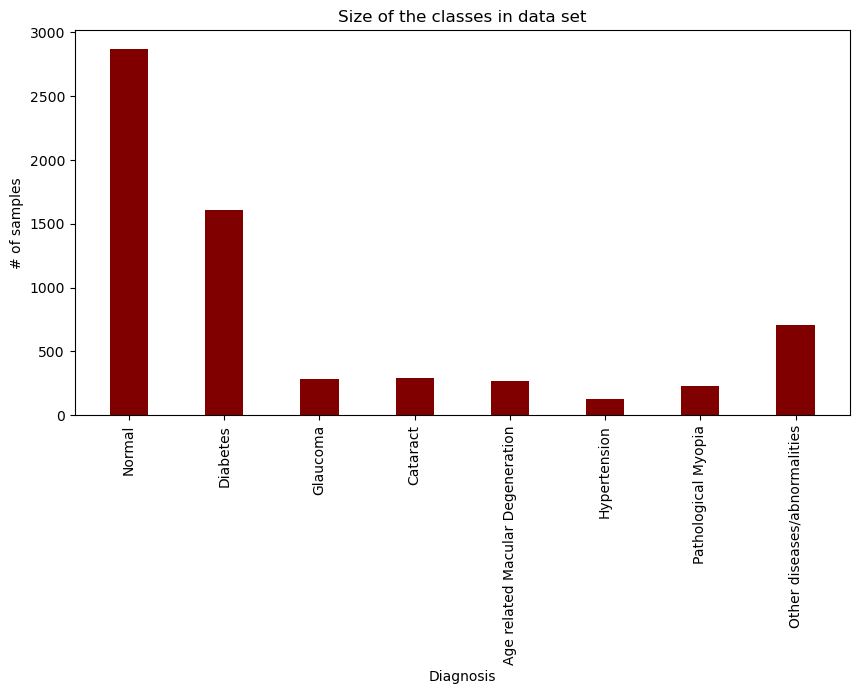

In [8]:
# creating the dataset
data = np.sum(targets, axis=0)

classes_names = list(classes.values())
values = list(data)
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classes_names, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Diagnosis")
plt.ylabel("# of samples")
plt.title("Size of the classes in data set")

plt.xticks(rotation=90)

plt.show()

Notice that the dataset is imbalanced however there are more that 100 sample images for each class therefore there should be enough data per class to train a classification problem.

### 1.4 Plotting example of each class

In [9]:
img_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"

In [10]:
raw_data["class_name"] = np.argmax(targets, axis=1).tolist()
raw_data["class_name"] = raw_data["class_name"] .replace(classes)

raw_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,filepath,target,filename,class_name
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,Normal
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,../input/ocular-disease-recognition-odir5k/ODI...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,Normal
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,Diabetes
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,Diabetes
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,../input/ocular-disease-recognition-odir5k/ODI...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,Diabetes


/tmp/ipykernel_22/4177161297.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_22/4177161297.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 4, 4 * i + j + 1)


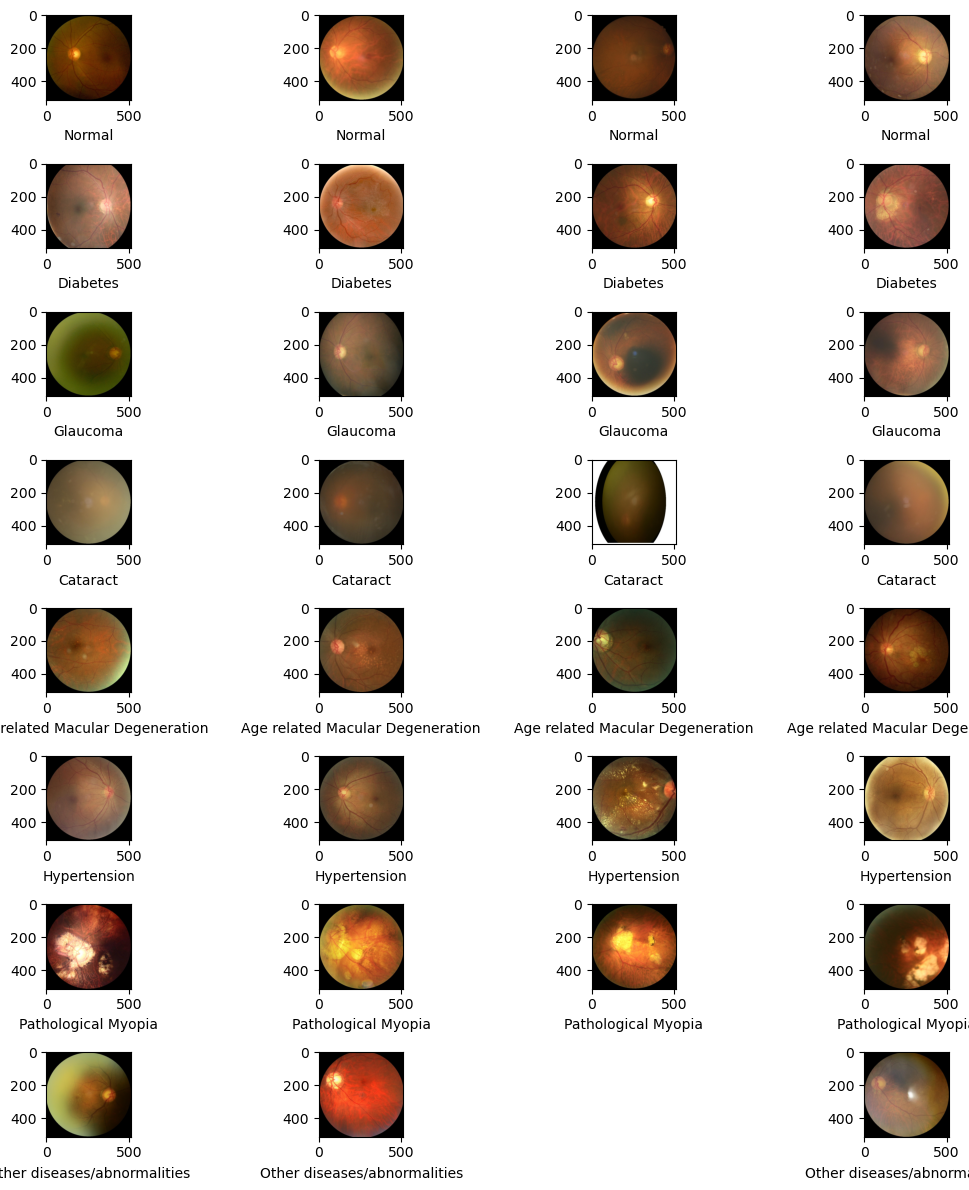

In [11]:
plt.figure(figsize=(12, 12))

for i, class_name in enumerate(classes.values()):
    
    class_subset = raw_data.loc[raw_data.class_name == class_name].sample(n=4)
    
    img_names = class_subset.filename.to_list()
    
    for j, img in enumerate(img_names):
        image = cv2.imread(os.path.join(img_dir, img))
        
        ## convert image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
        plt.subplot(8, 4, 4 * i + j + 1)
        plt.imshow(image_rgb, aspect=1)
        
        ## label with filename and diagnosis
        plt.xlabel('{}'.format(class_name))

        plt.tight_layout() 

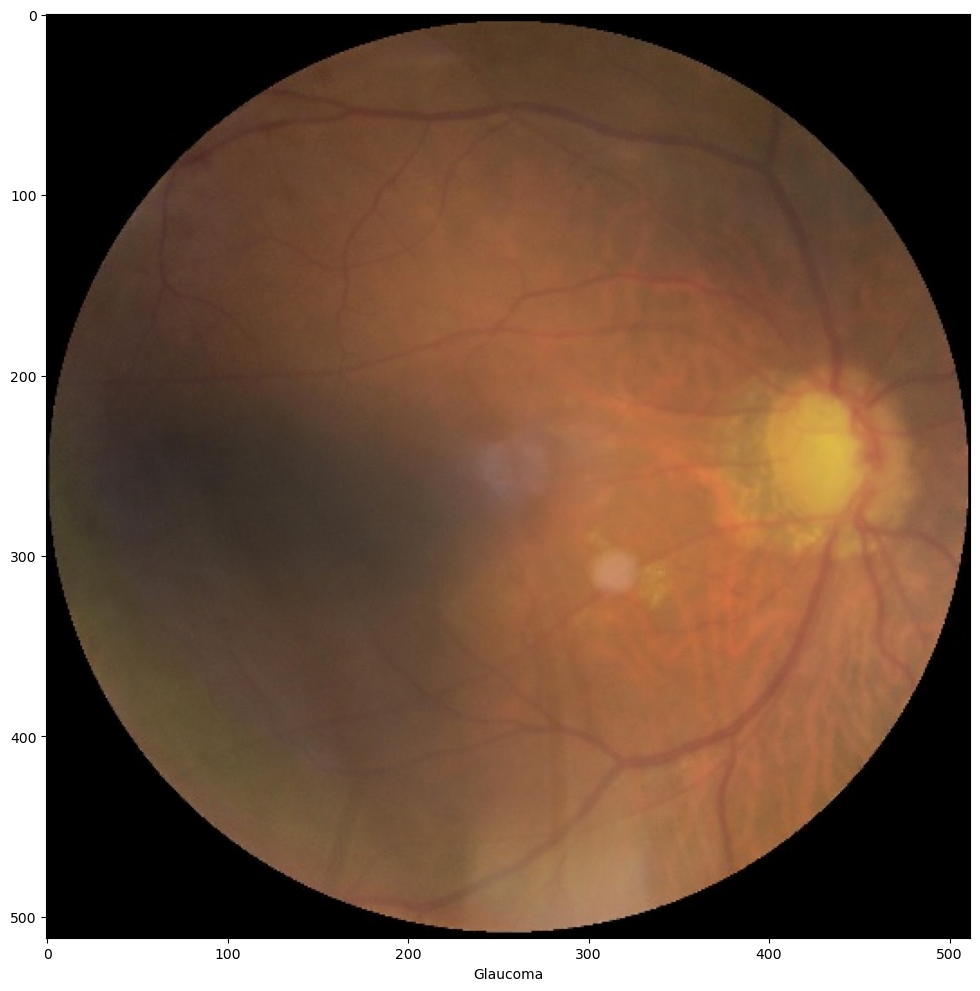

In [12]:
plt.figure(figsize=(12, 12))

single_class = ["Glaucoma"]

for i, class_name in enumerate(single_class):
    
    class_subset = raw_data.loc[raw_data.class_name == class_name].sample(n=4)
    
    img_names = class_subset.filename.to_list()
    
    for j, img in enumerate(img_names):
        image = cv2.imread(os.path.join(img_dir, img))
        
        ## convert image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
        # plt.subplot(8, 4, 4 * i + j + 1)
        plt.imshow(image_rgb, aspect=1)
        
        ## label with filename and diagnosis
        plt.xlabel('{}'.format(class_name))

### 1.5 Saving Cleaned Labels

In [13]:
processed_labels = raw_data[["ID", "filename", "class_name", "target"]]
processed_labels.to_csv('/kaggle/working/labels_clean.csv', index=False)

processed_labels.head()

,ID,filename,class_name,target
0,0,0_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1,1_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
2,2,2_right.jpg,Diabetes,"[0, 1, 0, 0, 0, 0, 0, 0]"
3,4,4_right.jpg,Diabetes,"[0, 1, 0, 0, 0, 0, 0, 0]"
4,5,5_right.jpg,Diabetes,"[0, 1, 0, 0, 0, 0, 0, 0]"


## 2. Import Libraries

In [14]:
# Import libraries
import json
import os
import pickle
import random
import time

# Ignore warnings
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from skimage import io, transform
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch dataset
from torchvision import datasets, models, transforms, utils
from torchvision.utils import make_grid

warnings.filterwarnings("ignore")

plt.ion()  # interactive mode

from __future__ import print_function, division

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [16]:
!nvidia-smi

Fri Sep  1 01:40:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

### 2.1 Define helper functions

In [17]:
def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    


In [18]:
def show_images(image):
    """Show image"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

## 3. Define `OcularDiseaseRecognition` class

In [19]:
class OcularDiseaseRecognition(Dataset):
    """Ocular Disease Recognition."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx, 1])
        image = io.imread(img_name)
        target = self.labels_frame.iloc[idx, 3]
        target = np.array(json.loads(target))
        sample = {'image': image, 'labels': target}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'labels': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'labels': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(label)}

## 4. Define Pytorch `Dataloader` & Load Data

### 4.1 Load Labels

In [20]:
!pwd

/kaggle/working


In [21]:
labels = pd.read_csv('/kaggle/working/labels_clean.csv')

n = 65
img_name = labels.iloc[n, 1]
class_name =  labels.iloc[n, 2]
target = labels.iloc[n, 3]

print('Image name: {}'.format(img_name))
print('Class Name: {}'.format(class_name))
print('Target: {}'.format(target))

Image name: 81_right.jpg
Class Name: Diabetes
Target: [0, 1, 0, 0, 0, 0, 0, 0]


In [22]:
labels.head(2)

,ID,filename,class_name,target
0,0,0_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1,1_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"


In [23]:
labels.shape

(6392, 4)

### 4.2 Load Image Data

In [24]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2
test_size = 0.2

In [25]:
# choose the training and test datasets
img_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"
labels_dir = '/kaggle/working/labels_clean.csv'

full_data  = OcularDiseaseRecognition(csv_file=labels_dir, 
                                      root_dir=img_dir, 
                                      transform=transforms.Compose([Rescale(512),
                                                                    ToTensor()])
                                     )

In [26]:
# obtain training indices that will be used for validation
num_train = len(full_data)
indices = list(range(num_train))

np.random.shuffle(indices)

val_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(valid_size * num_train))


test_idx, valid_idx, train_idx = indices[:test_split], indices[test_split: test_split + val_split], indices[test_split + val_split:]

In [27]:
num_train

6392

In [28]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler  = SubsetRandomSampler(test_idx)

In [29]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [30]:
len(train_loader)

120

### 4.3 Visualize a Batch of Training Data

In [31]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [32]:
# obtain one batch of training images
dataiter = iter(train_loader)
sample = next(dataiter)

sample['image'].shape # (number of examples: 20, number of channels: 3, pixel sizes: 256x256)

torch.Size([32, 3, 512, 512])

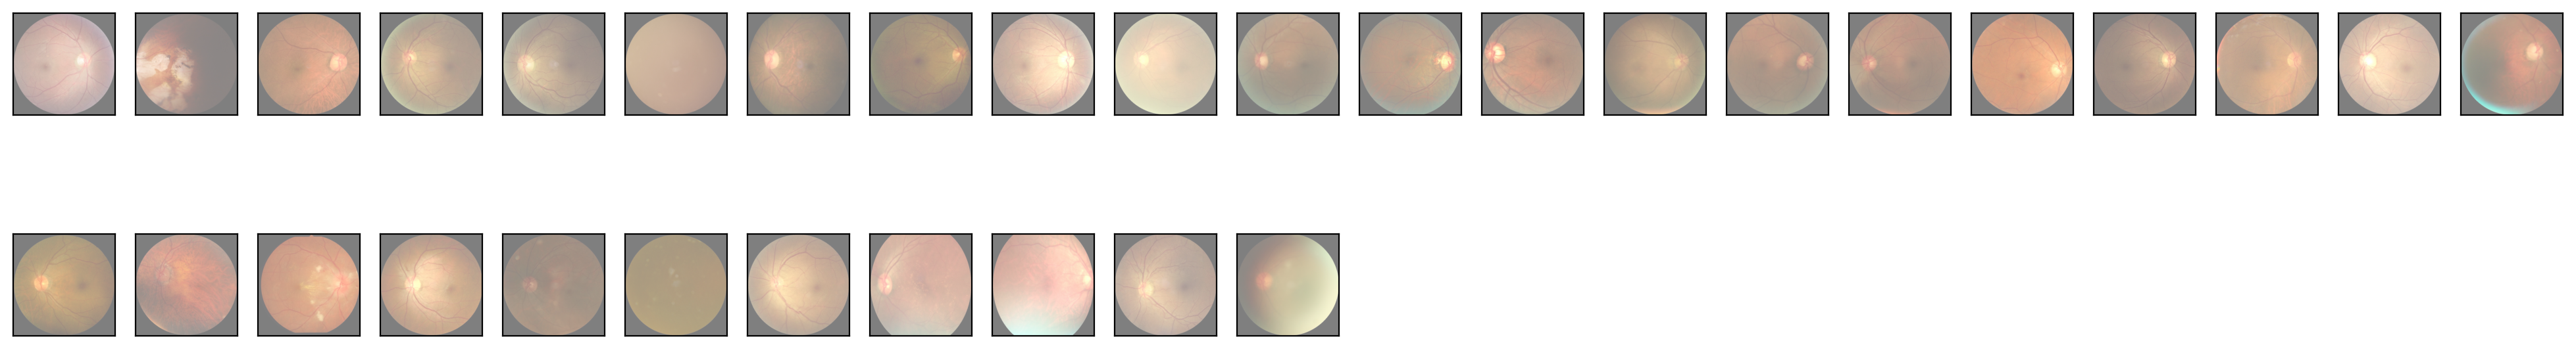

In [33]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 21, idx+1, xticks=[], yticks=[])
    imshow(sample['image'][idx])

## 5. Model Training

In [34]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

print(device_name)

cuda


In [35]:
def save_checkpoint(state, is_best, filename='/kaggle/working/bt_resnet50_ckpt_v2.pth.tar'):
    torch.save(state, filename)

### 5.1 Define Model Achitecture

In [36]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# set all parameters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.ReLU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.ReLU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 8),
                                nn.LogSigmoid())

# set all parameters of the model as trainable
for name, child in resnet_model.named_children():
    for name2, params in child.named_parameters():
        params.requires_grad = True


# Disbribute the model to all GPU's
resnet_model = nn.DataParallel(resnet_model)

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [37]:
# Limit maximum memory usage to 1GB

# torch.backends.cuda.reserved_memory = 4 * 1024 * 1024 * 1024
# torch.backends.cuda.max_allocated_memory = 4 * 1024 * 1024 * 1024

### 5.2 Define `Criterion` & `Optimizer`

In [38]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(resnet_model.parameters(), momentum=0.9, lr=3e-4)


# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

### 5.3 Run the Traing Loop

In [39]:
# number of training iterations
epochs = 32

In [40]:
torch.cuda.empty_cache()

In [41]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2
is_best = False

# empty batch variables
b = None
train_b = None
test_b = None

scaler = GradScaler()

for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    trn_loss = 0
    tst_loss = 0
    
    # set epoch's starting time
    e_start = time.time()
    

    # train in batches
    for b, sample in enumerate(train_loader):
        # set label as cuda if device is cuda
        X, y = sample['image'].to(device, dtype=torch.float), sample['labels'].to(device, dtype=torch.float)
        
        # forward pass image sample
        y_pred = resnet_model(X.view(-1, 3, 512, 512))

        # calculate loss
        loss = criterion(y_pred.float(), y.float())

        trn_loss += loss.item()
        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        y = torch.argmax(y, dim=1).data

        # if predicted label is correct as true label, calculate the sum for samples

        batch_corr = (predicted == y).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr.item()
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        # Backpropagate with autocasting
        # back propagate with loss
        scaler.scale(loss).backward()
        # perform optimizer step
        scaler.step(optimizer)
        scaler.update()
      
    # set epoch's end time
    e_end = time.time()
    
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)}\nAccuracy: {trn_corr*100/(b*batch_size):2.2f} %  Loss: {trn_loss/len(train_loader):2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') 
    
    # some metrics storage for visualization
    train_b = b
    train_losses.append(trn_loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, sample in enumerate(valid_loader):
            # set label as cuda if device is cuda
            X, y = sample['image'].to(device, dtype=torch.float), sample['labels'].to(device, dtype=torch.float)

            # forward pass image
            y_val = resnet_model(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data
            y = torch.argmax(y, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == y).sum().item()

            # get loss of validation set
            loss = criterion(y_val.float(), y.long())
            tst_loss += loss.item()
            
            
    # print validation metrics
    print(f'Validation Accuracy {tst_corr*100/(b*batch_size):2.2f}% Validation Loss: {tst_loss/len(valid_loader):2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    
    if is_best:
        save_checkpoint({
                'epoch': i + 1,
                'state_dict': resnet_model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best)
        
        is_best = False

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(tst_loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch 120
Accuracy: 41.44 %  Loss: 1.9363  Duration: 6.21 minutes
Validation Accuracy 47.04% Validation Loss: 1.7810

Epoch 2 Batch 120
Accuracy: 44.72 %  Loss: 1.6754  Duration: 6.06 minutes
Validation Accuracy 47.04% Validation Loss: 1.5640

Epoch 3 Batch 120
Accuracy: 44.72 %  Loss: 1.5573  Duration: 5.71 minutes
Validation Accuracy 47.04% Validation Loss: 1.5054

Epoch 4 Batch 120
Accuracy: 44.72 %  Loss: 1.5207  Duration: 5.69 minutes
Validation Accuracy 47.04% Validation Loss: 1.4751

Epoch 5 Batch 120
Accuracy: 44.72 %  Loss: 1.5002  Duration: 5.62 minutes
Validation Accuracy 47.04% Validation Loss: 1.4580

Epoch 6 Batch 120
Accuracy: 44.72 %  Loss: 1.4870  Duration: 5.59 minutes
Validation Accuracy 47.04% Validation Loss: 1.4410

Epoch 7 Batch 120
Accuracy: 44.72 %  Loss: 1.4729  Duration: 5.64 minutes
Validation Accuracy 47.04% Validation Loss: 1.4317

Epoch 8 Batch 120
Accuracy: 44.72 %  Loss: 1.4625  Duration: 5.60 minutes
Validation Accuracy 47.04% Validation Loss: 

In [42]:
print(f'Validation accuracy: {test_correct[-1]*100/(test_b*batch_size):.2f}%')

Validation accuracy: 59.13%


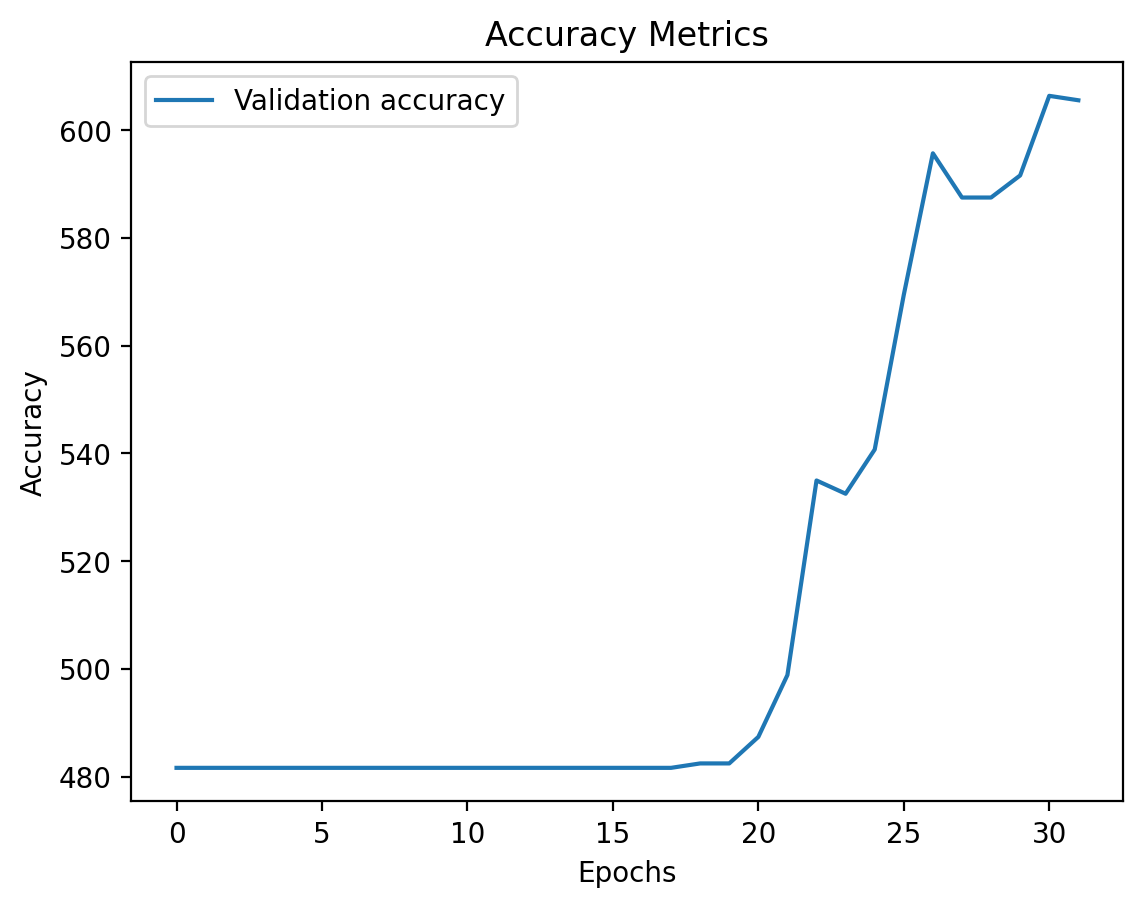

In [43]:
plt.plot([t/test_b*batch_size for t in torch.tensor(test_correct).cpu()], label='Validation accuracy')

plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend()
plt.show()